## Recurrent Variational Autoencoders
Autoencoders for input reconstruction using the GConvLSTM for encoding.

### Recurrent decoder model
The first model uses a vanilla LSTM cell for decoding. <br />
The hidden state from the encoder RNN is used to predict the last time-step of the input <br />
and as the initial hidden state of the decoder RNN. The decoder then reconstructs the time series <br />
in reverse using the last recostructed value as input for each step. <br />
<br />
The loss is chosen as the MSE of the reconstruction with the input scaled by the KL-Divergence of $P(Z;X)$: <br />

$\frac{1}{n}\sum_{i=1}^n(X_i-\hat{X_i})^2 + \gamma D_{KL}(q_\Phi(\mathbf{z\mid x}) \parallel p_\theta(\mathbf{z}))$ <br /><br />

### Linear decoder model
The second model uses as linear probabilistic decoder parameterizing <br />
both mean $\theta$ and standard deviation $\Phi$ of $P(\hat{X};Z)$. <br />

The loss is the typical VAE loss: <br />

$L_{\theta,\Phi} = -\log (p_\theta(\mathbf{x})) + D_{KL}(q_\Phi(\mathbf{z\mid x})\parallel p_\theta(\mathbf{z\mid x})) = -E_{\mathbf{z} \sim q_\Phi(\mathbf{z|x})}(\log(p_\theta(\mathbf{x\mid z}))) + D_{KL}(q_\Phi(\mathbf{z\mid x}) \parallel p_\theta(\mathbf{z}))$
<br />

### GConvLSTM encoder - LSTM decoder

100%|██████████| 200/200 [18:43<00:00,  5.62s/it]


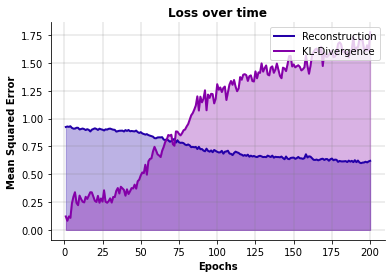

Train MSE: 0.6208
Test MSE: 0.7135


In [2]:
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import GConvLSTM

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

lags = 10
stride = 1
epochs = 200

dataset = loader.get_dataset(lags)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

### MODEL DEFINITION
class RecurrentGCVAE(nn.Module):
    def __init__(self, node_features, window_length):
        super(RecurrentGCVAE, self).__init__()
        
        self.n = window_length
        hidden_state_size = 64
        latent_dim = 16
        
        self.encoder_rnn = GConvLSTM(node_features, hidden_state_size, 1)

        self.latent = nn.Linear(hidden_state_size, 2*latent_dim)

        self.decoder_input = nn.Linear(latent_dim, hidden_state_size)
        self.decoder_rnn = nn.LSTMCell(input_size=1, hidden_size=hidden_state_size)

        self.reconstruct = nn.Linear(hidden_state_size, 1)

    def forward(self, window, h, c):   
        x = window.x
        edge_index = window.edge_index
        edge_weight = None
    
        H, C = [], []
        
        for t in range(self.n):
            x_t = x[:,t].unsqueeze(0).T
            h, c = self.encoder_rnn(x_t, edge_index, edge_weight, h, c)
            
            H.append(h.detach())
            C.append(c.detach())
            
        mu_z, logvar_z = self.latent(h).chunk(2, dim=-1)

        std_z = torch.exp(0.5 * logvar_z)
        eps = torch.randn_like(std_z)

        z = std_z * eps + mu_z
        
        h = self.decoder_input(z)
        c = torch.zeros_like(h)
        
        x_hat = self.reconstruct(h)
        x_rec = [x_hat]
        for t in range(self.n-1):
            h, c = self.decoder_rnn(x_hat, (h, c))
            x_hat = self.reconstruct(h)

            x_rec.append(x_hat)

        x_rec = torch.cat(x_rec[::-1], dim=1)
        kld = torch.mean(-0.5 * torch.sum(1 + logvar_z - (mu_z ** 2) - logvar_z.exp(), dim = 1))

        return x_rec, kld, H, C
    
model = RecurrentGCVAE(node_features=1, window_length=lags)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
kld_weight = 0.5

### TRAIN
model.train()

loss_history = []
kld_history = []

for _ in tqdm(range(epochs)):
    h, c = None, None
    avg_rec_loss = 0
    avg_kld = 0
    for i, window in enumerate(train_dataset):
        optimizer.zero_grad()

        x_rec, kld, H, C = model(window, h, c)

        rec_loss = torch.mean((x_rec - window.x)**2)
        loss = kld_weight * kld + rec_loss

        h = H[stride-1]
        c = C[stride-1]
        
        avg_rec_loss += rec_loss.item()
        avg_kld += kld.item()
        
        loss.backward()
        optimizer.step()
    avg_rec_loss /= i+1
    avg_kld /= i+1

    loss_history.append(avg_rec_loss)
    kld_history.append(avg_kld)
train_loss = avg_rec_loss

### TEST 
model.eval()
rec_loss = 0
with torch.no_grad():
    h, c = None, None
    for i, window in enumerate(test_dataset):
        x_rec, _, H, C = model(window, h, c)
        
        rec_loss += torch.mean((x_rec - window.x)**2).item()
        
    rec_loss /= i+1
test_loss = rec_loss

### RESULTS PLOT
colors = ['#2300a8', '#8400a8'] # '#8400a8', '#00A658'
plot_dict = {'Reconstruction': (loss_history, colors[0]), 'KL-Divergence': (kld_history, colors[1])}

n = len(loss_history)

# plot train and val losses and log_likelihood area under the curve
fig, ax = plt.subplots()
x_axis = list(range(1, n+1))
for key, (data, color) in plot_dict.items():
    ax.plot(x_axis, data, 
                label=key, 
                linewidth=2, 
                linestyle='-', 
                alpha=1, 
                color=color)
    ax.fill_between(x_axis, data, 
                alpha=0.3, 
                color=color)

# figure labels
ax.set_title('Loss over time', fontweight='bold')
ax.set_xlabel('Epochs', fontweight='bold')
ax.set_ylabel('Mean Squared Error', fontweight='bold')
ax.legend(loc='upper left')

# remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# adds major gridlines
ax.grid(color='grey', linestyle='-', linewidth=0.35, alpha=0.8)

# y-axis in log scale (reconstruction loss tends to start high)
# ax.set_yscale('log')
plt.show()

print("Train MSE: {:.4f}".format(train_loss))
print("Test MSE: {:.4f}".format(test_loss))


### GConvLSTM encoder - Linear decoder

100%|██████████| 200/200 [26:34<00:00,  7.97s/it]


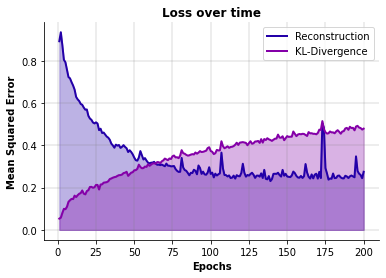

Train MSE: 0.2749
Test MSE: 0.1889


In [3]:
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch_geometric_temporal.nn.recurrent import GConvLSTM
import torch.nn.functional as F

from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

lags = 10
stride = 1
epochs = 200

dataset = loader.get_dataset(lags)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)

class RecurrentGCVAE_Lin(nn.Module):
    def __init__(self, node_features, window_length):
        super(RecurrentGCVAE_Lin, self).__init__()
        
        self.n = window_length
        hidden_state_size = 64
        latent_dim = 32
        
        self.encoder = GConvLSTM(node_features, hidden_state_size, 1)
        self.latent = nn.Linear(hidden_state_size, 2*latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_state_size),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_state_size, 2*window_length),
            nn.Flatten(start_dim=0, end_dim=-2)
        )

    def forward(self, window, h, c):        
        edge_index = window.edge_index
        edge_weight = None
    
        H, C = [], []
        
        for t in range(self.n):
            x = window.x[:,t].unsqueeze(0).T
            h, c = self.encoder(x, edge_index, edge_weight, h, c)
            
            H.append(h.detach())
            C.append(c.detach())
            
        mu_z, logvar_z = self.latent(h).chunk(2, dim=-1)

        std_z = torch.exp(0.5 * logvar_z)
        eps = torch.randn_like(std_z)

        h = std_z * eps + mu_z
        
        mu_x, logvar_x = self.decoder(h).chunk(2, dim=-1)

        kld = torch.mean(-0.5 * torch.mean(1 + logvar_z - (mu_z ** 2) - logvar_z.exp(), dim = 1))

        return mu_x, logvar_x, kld, H, C
    
model = RecurrentGCVAE_Lin(node_features=1, window_length=lags)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
kld_weight = 0.5

### TRAIN
model.train()

loss_history = []
kld_history = []

for _ in tqdm(range(epochs)):
    h, c = None, None
    rec_loss = 0
    avg_kld = 0
    for i, window in enumerate(train_dataset):
        optimizer.zero_grad()

        mu_x, logvar_x, kld, H, C = model(window, h, c)

        log_likelihood = -((window.x - mu_x) ** 2) / (2 * torch.exp(logvar_x)) - logvar_x - math.log(math.sqrt(2 * math.pi))

        loss = kld_weight * kld - log_likelihood.mean()

        h = H[stride-1]
        c = C[stride-1]
        
        rec_loss += torch.mean((mu_x - window.x)**2).item()
        avg_kld += kld.item()
                
        loss.backward()
        optimizer.step()
    rec_loss /= i+1
    avg_kld /= i+1

    kld_history.append(avg_kld)
    loss_history.append(rec_loss)
    
train_loss = rec_loss

### TEST 
model.eval()
rec_loss = 0
with torch.no_grad():
    h, c = None, None
    for i, window in enumerate(test_dataset):
        mu_x, _, _, H, C = model(window, h, c)
        
        rec_loss += torch.mean((mu_x - window.x)**2).item()
        
    rec_loss /= i+1
test_loss = rec_loss

### RESULTS PLOT
colors = ['#2300a8', '#8400a8'] # '#8400a8', '#00A658'
plot_dict = {'Reconstruction': (loss_history, colors[0]), 'KL-Divergence': (kld_history, colors[1])}

n = len(loss_history)

# plot train and val losses and log_likelihood area under the curve
fig, ax = plt.subplots()
x_axis = list(range(1, n+1))
for key, (data, color) in plot_dict.items():
    ax.plot(x_axis, data, 
                label=key, 
                linewidth=2, 
                linestyle='-', 
                alpha=1, 
                color=color)
    ax.fill_between(x_axis, data, 
                alpha=0.3, 
                color=color)

# figure labels
ax.set_title('Loss over time', fontweight='bold')
ax.set_xlabel('Epochs', fontweight='bold')
ax.set_ylabel('Mean Squared Error', fontweight='bold')
ax.legend(loc='upper right')

# remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# adds major gridlines
ax.grid(color='grey', linestyle='-', linewidth=0.35, alpha=0.8)

# y-axis in log scale (reconstruction loss tends to start high)
# ax.set_yscale('log')
plt.show()
    
print("Train MSE: {:.4f}".format(train_loss))
print("Test MSE: {:.4f}".format(test_loss))
